# Imports

In [1]:
# Standard libraries
import random
from collections import Counter

# External libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG19
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "./dataset/complete_dataset"

##  Name of classes 
CLASSES = ['glioma',
           'meningioma',
           'no_tumor',
           'pituitary']

# Load, Rescale and One Hot Encoding of imgs

In [3]:
# Initialize empty lists for images (X) and labels (y)
X, y = [], []

# Rescale images' pixel values from [0, 255] to [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and resize images to 170x170, shuffle randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(170, 170),batch_size=7023, shuffle=True)

# Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 7023 images belonging to 4 classes.


In [4]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (7023, 170, 170, 3)
Labels shape :	 (7023, 4)


In [5]:
# Number of samples in each class
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

# Class labels as per their indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 1621), (1, 1645), (2, 2000), (3, 1757)]
Classes Names according to index:	 {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


# Random samples from dataset

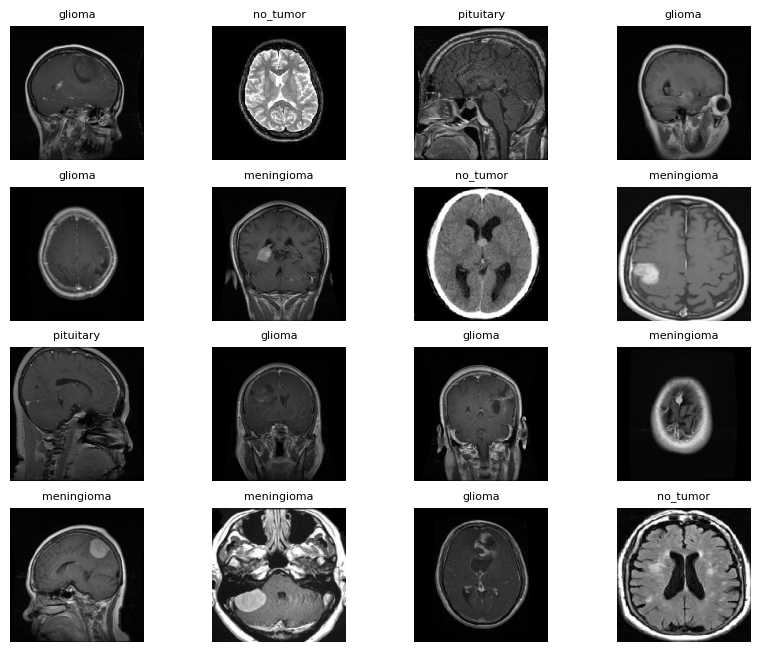

In [6]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

# Splitting the Dataset

In [7]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after splitting into Training, Validation, and Test sets
print("Number of samples after splitting into Training, validation & test set\n")

# Display the number of samples in each class for Train, Validation, and Test sets
print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 1042), (1, 1048), (2, 1293), (3, 1111)]
Validation	 [(0, 310), (1, 337), (2, 399), (3, 359)]
Test      	 [(0, 269), (1, 260), (2, 308), (3, 287)]


In [8]:
del X, y # no more required

# Training and Evaluating Models

## InceptionV3 Model

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(170, 170, 3))

# Create a new model on top of the base model
InceptionV3_model = Sequential()

InceptionV3_model.add(base_model)

InceptionV3_model.add(Dropout(0.10))

InceptionV3_model.add(Flatten())

InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(768, activation='relu'))
InceptionV3_model.add(Dropout(0.30))

InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(384, activation='relu'))
InceptionV3_model.add(Dropout(0.30))

InceptionV3_model.add(Dense(4, activation='softmax'))

base_model.summary()

InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 170, 170, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 84, 84, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 84, 84, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [10]:
### Model Compilation
InceptionV3_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [11]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [12]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = InceptionV3_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 30,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/30
561/561 [==============================] - 58s 82ms/step - loss: 0.9202 - acc: 0.6596 - auc: 0.8732 - precision: 0.6961 - recall: 0.6141 - val_loss: 0.3384 - val_acc: 0.8848 - val_auc: 0.9782 - val_precision: 0.8951 - val_recall: 0.8687 - lr: 0.0100
Epoch 2/30
561/561 [==============================] - 44s 79ms/step - loss: 0.5120 - acc: 0.8214 - auc: 0.9546 - precision: 0.8404 - recall: 0.7996 - val_loss: 0.4385 - val_acc: 0.8554 - val_auc: 0.9704 - val_precision: 0.8641 - val_recall: 0.8455 - lr: 0.0100
Epoch 3/30
561/561 [==============================] - 44s 79ms/step - loss: 0.4039 - acc: 0.8513 - auc: 0.9709 - precision: 0.8687 - recall: 0.8391 - val_loss: 0.2028 - val_acc: 0.9321 - val_auc: 0.9920 - val_precision: 0.9441 - val_recall: 0.9196 - lr: 0.0100
Epoch 4/30
561/561 [==============================] - 44s 79ms/step - loss: 0.2830 - acc: 0.9046 - auc: 0.9849 - precision: 0.9140 - recall: 0.8957 - val_loss: 0.1661 - val_acc: 0.9491 - val_auc: 0.9931 - val_precisio

In [13]:
InceptionV3_model.save('./InceptionV3_SGD.h5')

In [14]:
test_scores = InceptionV3_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 6s 21ms/step - loss: 0.0516 - acc: 0.9840 - auc: 0.9992 - precision: 0.9840 - recall: 0.9831
Testing Accuracy: 	 98.398578 %
Testing AC: 		 99.915898 %
Testing Precision: 	 98.397148 %
Testing Recall: 	 98.309606 %
Testing F1-Score: 	 98.353358 %


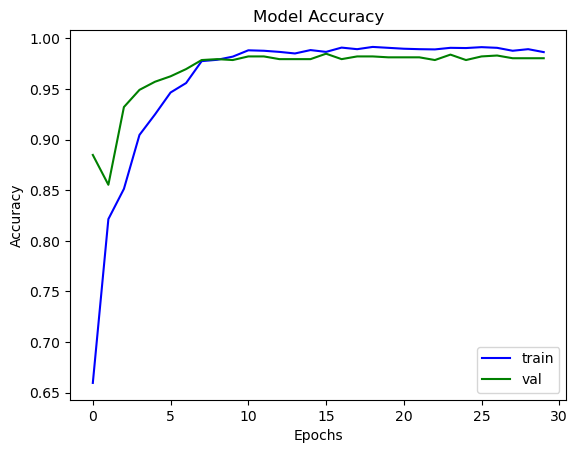

In [15]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

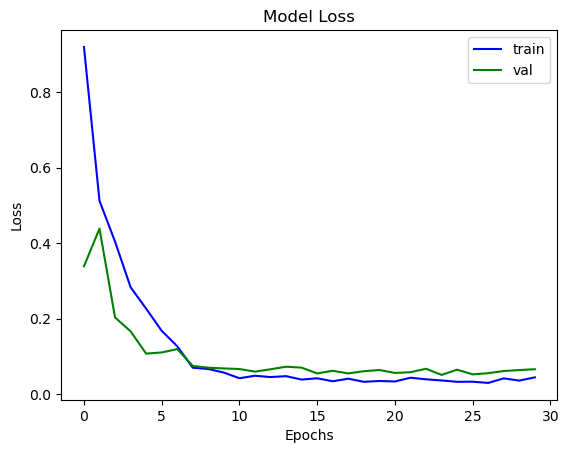

In [16]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

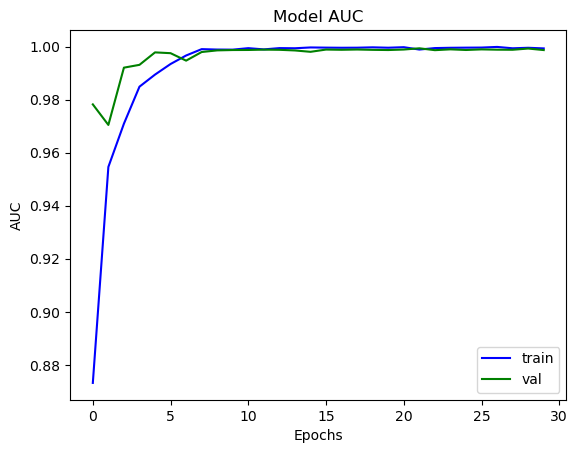

In [17]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

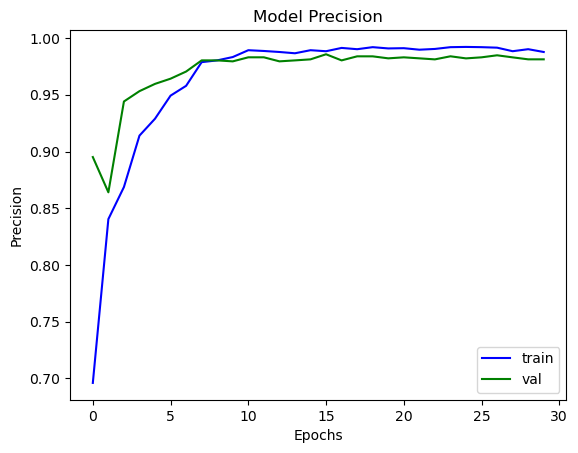

In [18]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

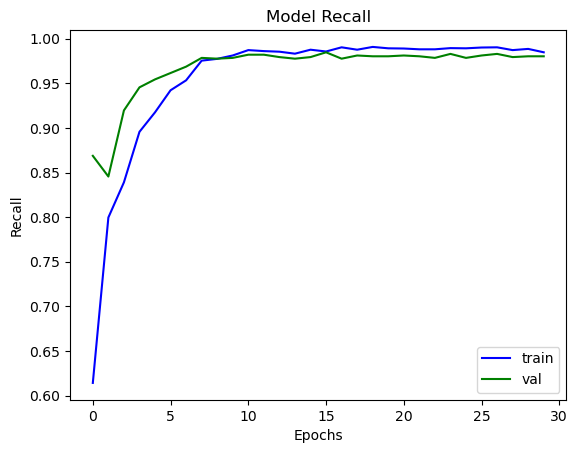

In [19]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [20]:
del history #no more required

In [21]:
pred_labels = InceptionV3_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))

281/281 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       269
  meningioma       0.98      0.97      0.97       260
    no_tumor       0.99      0.99      0.99       308
   pituitary       0.99      0.98      0.98       287

   micro avg       0.98      0.98      0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124
 samples avg       0.98      0.98      0.98      1124



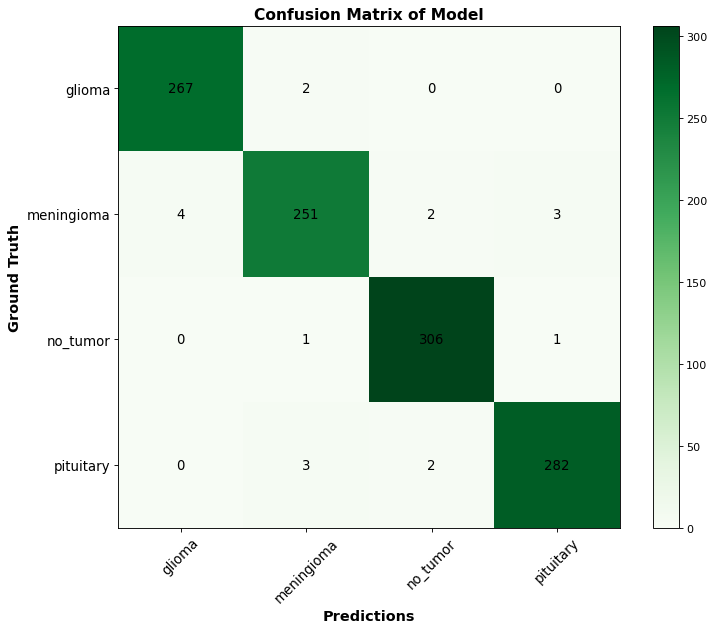

In [22]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


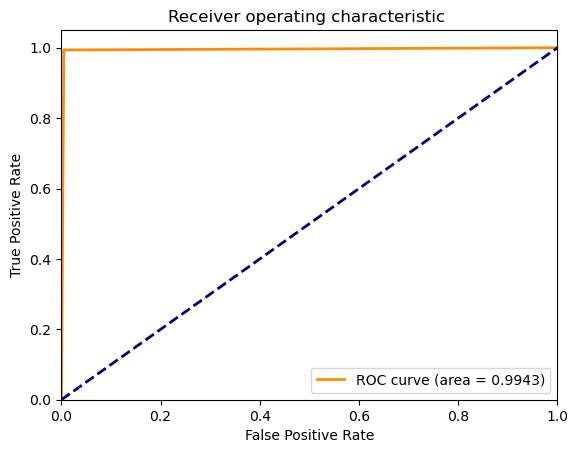

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

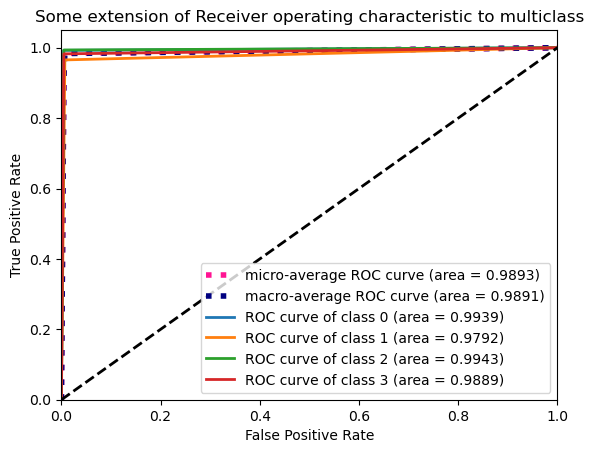

In [24]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## ResNet50 Model

In [25]:
# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(170, 170, 3))

# Create a new model on top of the base ResNet50 model
ResNet50_model = Sequential()

# Add the ResNet50 base model
ResNet50_model.add(base_model)

ResNet50_model.add(Dropout(0.10))

ResNet50_model.add(Flatten())

ResNet50_model.add(BatchNormalization())
ResNet50_model.add(Dense(768, activation='relu'))
ResNet50_model.add(Dropout(0.30))

ResNet50_model.add(Dense(384, activation='relu'))
ResNet50_model.add(Dropout(0.30))

ResNet50_model.add(Dense(4, activation='softmax'))

base_model.summary()

ResNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 170, 170, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 176, 176, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 85, 85, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 85, 85, 64)   256         ['conv1_conv[0][0]']      

In [26]:
### Model Compilation
ResNet50_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [27]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [28]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = ResNet50_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 30,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/30
561/561 [==============================] - 61s 100ms/step - loss: 0.7623 - acc: 0.7688 - auc: 0.9277 - precision: 0.7868 - recall: 0.7445 - val_loss: 1.8464 - val_acc: 0.2679 - val_auc: 0.5381 - val_precision: 0.2615 - val_recall: 0.1875 - lr: 0.0100
Epoch 2/30
561/561 [==============================] - 55s 98ms/step - loss: 0.3106 - acc: 0.8923 - auc: 0.9823 - precision: 0.9012 - recall: 0.8827 - val_loss: 0.1490 - val_acc: 0.9500 - val_auc: 0.9953 - val_precision: 0.9533 - val_recall: 0.9473 - lr: 0.0100
Epoch 3/30
561/561 [==============================] - 55s 98ms/step - loss: 0.2133 - acc: 0.9267 - auc: 0.9905 - precision: 0.9337 - recall: 0.9231 - val_loss: 0.1598 - val_acc: 0.9473 - val_auc: 0.9942 - val_precision: 0.9523 - val_recall: 0.9446 - lr: 0.0100
Epoch 4/30
561/561 [==============================] - 56s 99ms/step - loss: 0.1381 - acc: 0.9532 - auc: 0.9951 - precision: 0.9579 - recall: 0.9494 - val_loss: 0.1436 - val_acc: 0.9652 - val_auc: 0.9953 - val_precisi

In [29]:
ResNet50_model.save('./ResNet50_SGD.h5')

In [30]:
test_scores = ResNet50_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 6s 21ms/step - loss: 0.0545 - acc: 0.9831 - auc: 0.9974 - precision: 0.9831 - recall: 0.9831
Testing Accuracy: 	 98.309606 %
Testing AC: 		 99.739355 %
Testing Precision: 	 98.309606 %
Testing Recall: 	 98.309606 %
Testing F1-Score: 	 98.309606 %


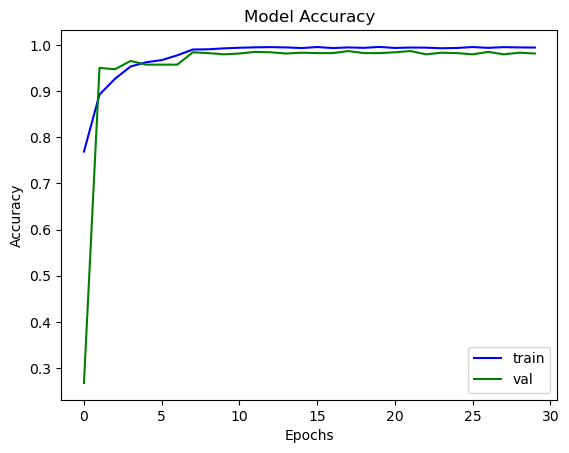

In [31]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

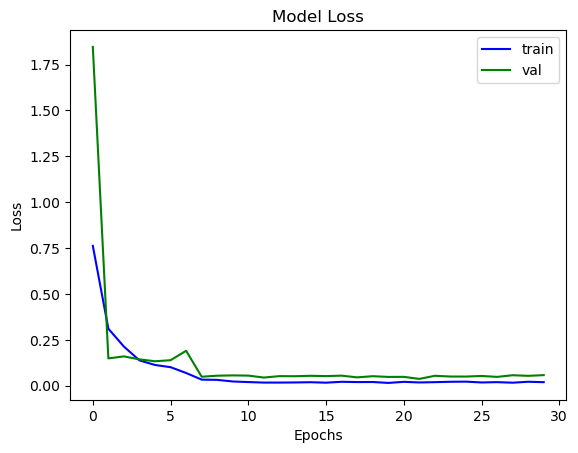

In [32]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

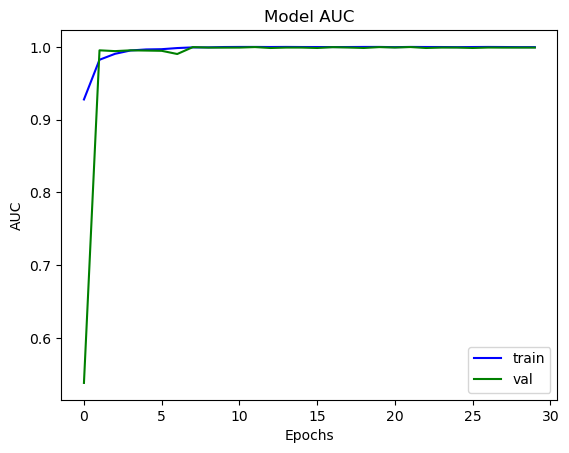

In [33]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

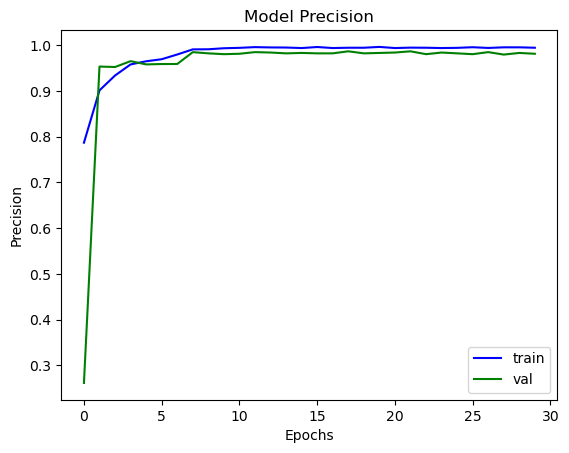

In [34]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

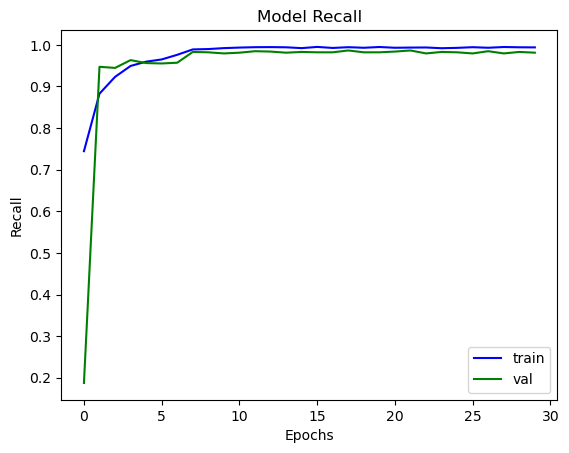

In [35]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [36]:
del history #no more required

In [37]:
pred_labels = ResNet50_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))

281/281 [==============================] - 5s 16ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       269
  meningioma       0.96      0.97      0.97       260
    no_tumor       0.99      0.99      0.99       308
   pituitary       0.99      0.99      0.99       287

   micro avg       0.98      0.98      0.98      1124
   macro avg       0.98      0.98      0.98      1124
weighted avg       0.98      0.98      0.98      1124
 samples avg       0.98      0.98      0.98      1124



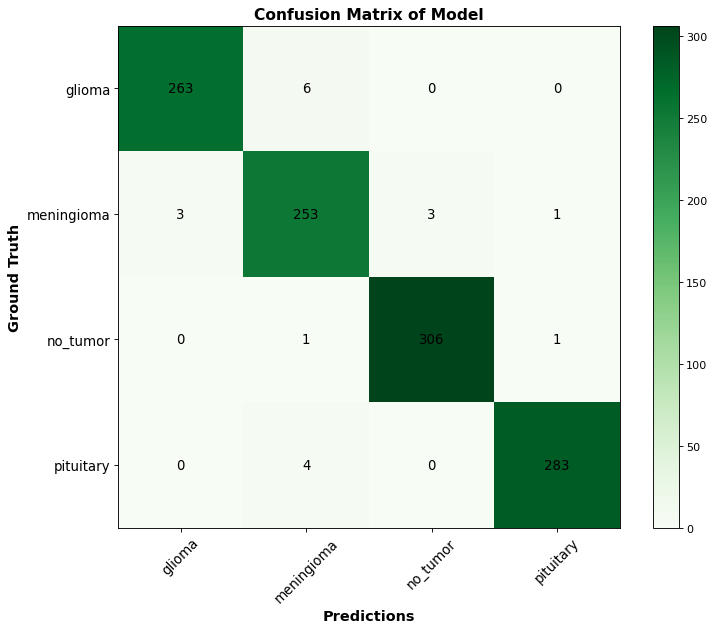

In [38]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


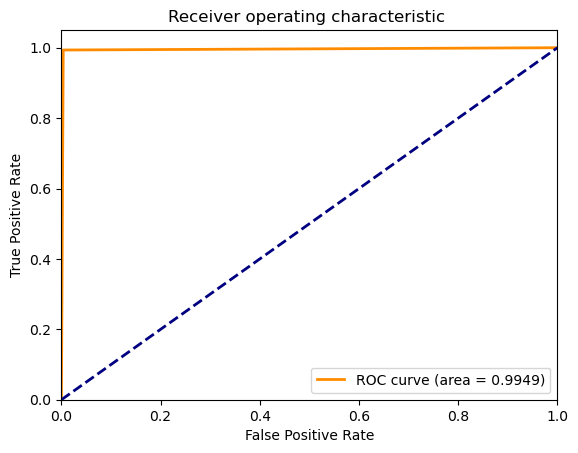

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

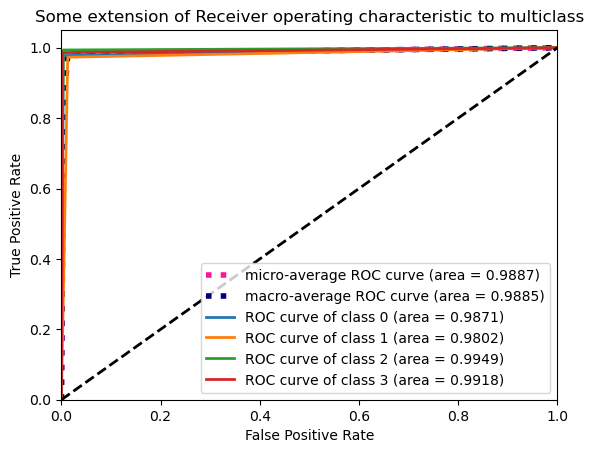

In [40]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## VGG19 Model

In [41]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(170, 170, 3))

# Create a new model on top of the base VGG19 model
VGG19_model = Sequential()

# Add the VGG19 base model
VGG19_model.add(base_model)

VGG19_model.add(Dropout(0.10))

VGG19_model.add(Flatten())

VGG19_model.add(BatchNormalization())
VGG19_model.add(Dense(768, activation='relu'))
VGG19_model.add(Dropout(0.30))

VGG19_model.add(Dense(384, activation='relu'))
VGG19_model.add(Dropout(0.30))

VGG19_model.add(Dense(4, activation='softmax'))

base_model.summary()

VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 170, 170, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 170, 170, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 170, 170, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 85, 85, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 85, 85, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 85, 85, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 42, 42, 128)       0     

In [42]:
### Model Compilation
VGG19_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [43]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = VGG19_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 30,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/30
561/561 [==============================] - 549s 971ms/step - loss: 0.9219 - acc: 0.6099 - auc: 0.8525 - precision: 0.6965 - recall: 0.4989 - val_loss: 3.4533 - val_acc: 0.2268 - val_auc: 0.5437 - val_precision: 0.2331 - val_recall: 0.2250 - lr: 0.0100
Epoch 2/30
561/561 [==============================] - 91s 162ms/step - loss: 0.8077 - acc: 0.6701 - auc: 0.8879 - precision: 0.7518 - recall: 0.5504 - val_loss: 7.5577 - val_acc: 0.2304 - val_auc: 0.5115 - val_precision: 0.2319 - val_recall: 0.2286 - lr: 0.0100
Epoch 3/30
561/561 [==============================] - 89s 159ms/step - loss: 0.7147 - acc: 0.7191 - auc: 0.9126 - precision: 0.7681 - recall: 0.6540 - val_loss: 4.9017 - val_acc: 0.2214 - val_auc: 0.5785 - val_precision: 0.2214 - val_recall: 0.2214 - lr: 0.0100
Epoch 4/30
561/561 [==============================] - 89s 159ms/step - loss: 0.5255 - acc: 0.7963 - auc: 0.9518 - precision: 0.8322 - recall: 0.7597 - val_loss: 1.6067 - val_acc: 0.4295 - val_auc: 0.7365 - val_pre

In [44]:
VGG19_model.save('./VGG19_SGD.h5')

In [45]:
test_scores = VGG19_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 9s 28ms/step - loss: 0.2569 - acc: 0.9084 - auc: 0.9863 - precision: 0.9200 - recall: 0.9004
Testing Accuracy: 	 90.836298 %
Testing AC: 		 98.627990 %
Testing Precision: 	 92.000002 %
Testing Recall: 	 90.035588 %
Testing F1-Score: 	 91.007195 %


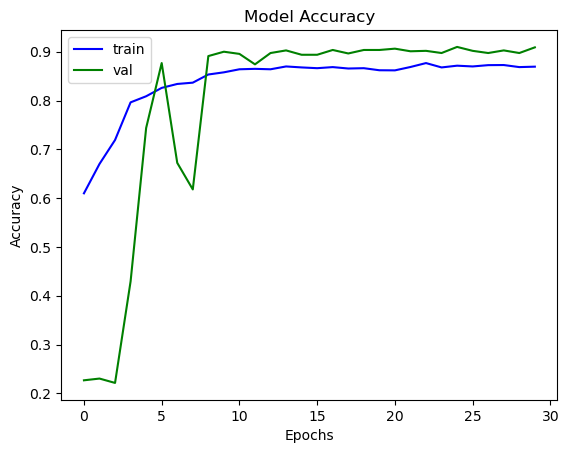

In [46]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

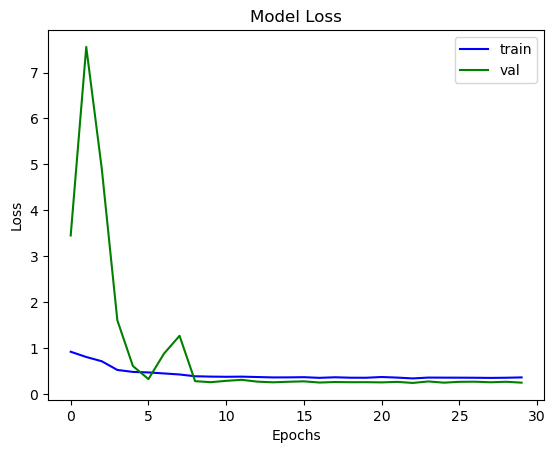

In [47]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

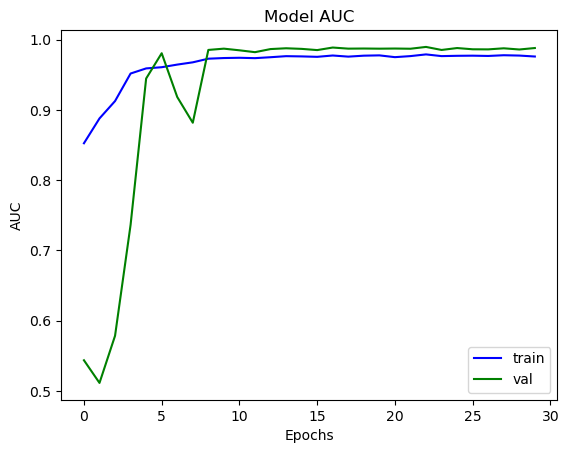

In [48]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

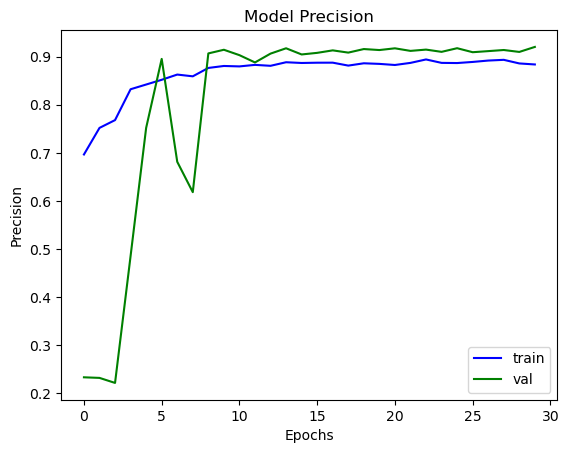

In [49]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

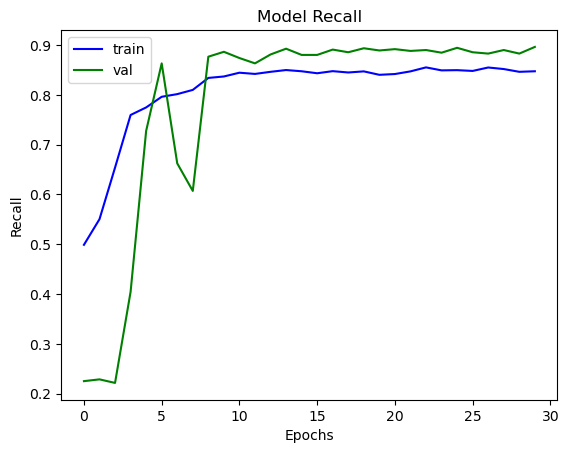

In [50]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [51]:
del history #no more required

In [52]:
pred_labels = VGG19_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))

281/281 [==============================] - 7s 26ms/step
              precision    recall  f1-score   support

      glioma       0.91      0.90      0.91       269
  meningioma       0.86      0.77      0.81       260
    no_tumor       0.94      0.97      0.96       308
   pituitary       0.91      0.97      0.94       287

   micro avg       0.91      0.91      0.91      1124
   macro avg       0.91      0.90      0.90      1124
weighted avg       0.91      0.91      0.91      1124
 samples avg       0.91      0.91      0.91      1124



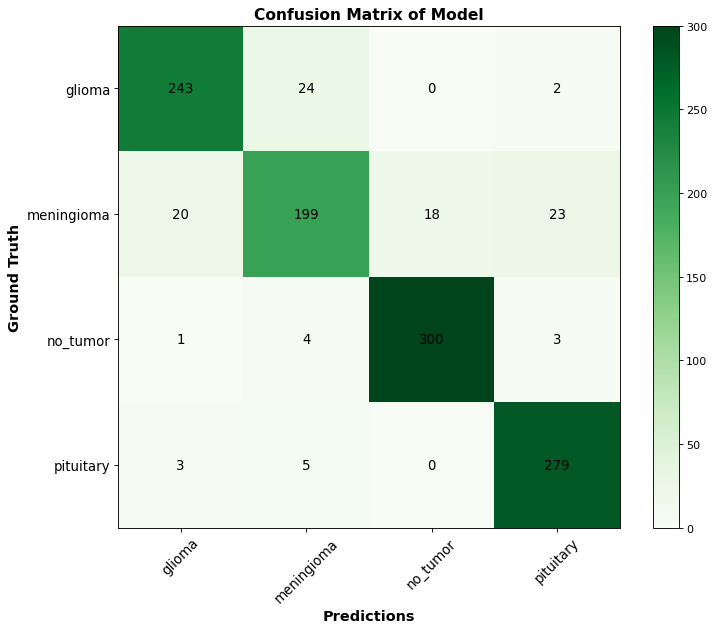

In [53]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


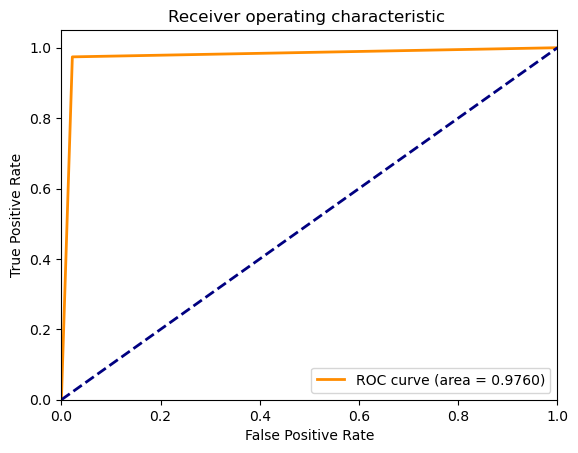

In [54]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

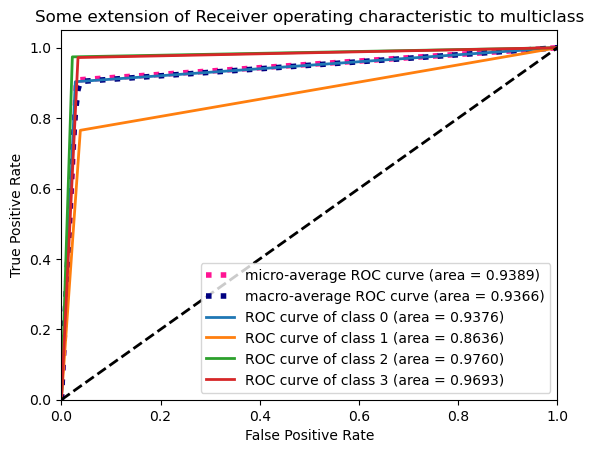

In [55]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## TDD Net (Proposed Model)

In [56]:
init = HeNormal()

TDD_model = Sequential()

TDD_model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer=init, input_shape=(170, 170, 3)))
TDD_model.add(AveragePooling2D(pool_size=(2,2)))

TDD_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=init))
TDD_model.add(AveragePooling2D(pool_size=(2,2)))

TDD_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init))
TDD_model.add(AveragePooling2D(pool_size=(2,2)))

TDD_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=init))
TDD_model.add(AveragePooling2D(pool_size=(2,2)))

TDD_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer=init))
TDD_model.add(AveragePooling2D(pool_size=(2,2)))

TDD_model.add(Dropout(0.10))

TDD_model.add(Flatten())


TDD_model.add(BatchNormalization())
TDD_model.add(Dense(768, activation='relu'))
TDD_model.add(Dropout(0.30))

TDD_model.add(Dense(384, activation='relu'))
TDD_model.add(Dropout(0.30))

TDD_model.add(Dense(4, activation='softmax'))

TDD_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 168, 168, 16)      448       
                                                                 
 average_pooling2d_9 (Averag  (None, 84, 84, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_95 (Conv2D)          (None, 82, 82, 32)        4640      
                                                                 
 average_pooling2d_10 (Avera  (None, 41, 41, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_96 (Conv2D)          (None, 39, 39, 64)        18496     
                                                                 
 average_pooling2d_11 (Avera  (None, 19, 19, 64)      

c:\Users\mayan\.conda\envs\tf210\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [57]:
### Model Compilation
TDD_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") 
       ])

In [58]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [59]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = TDD_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 30,
batch_size=batch_size,
callbacks=CALLBACKS
)

Epoch 1/30
561/561 [==============================] - 9s 14ms/step - loss: 0.9813 - acc: 0.5872 - auc: 0.8314 - precision: 0.6761 - recall: 0.4485 - val_loss: 0.9992 - val_acc: 0.5348 - val_auc: 0.8112 - val_precision: 0.7841 - val_recall: 0.3696 - lr: 0.0100
Epoch 2/30
561/561 [==============================] - 7s 12ms/step - loss: 0.7735 - acc: 0.6917 - auc: 0.8965 - precision: 0.7528 - recall: 0.5994 - val_loss: 0.6000 - val_acc: 0.7652 - val_auc: 0.9366 - val_precision: 0.7972 - val_recall: 0.7125 - lr: 0.0100
Epoch 3/30
561/561 [==============================] - 7s 13ms/step - loss: 0.6331 - acc: 0.7434 - auc: 0.9307 - precision: 0.7878 - recall: 0.6884 - val_loss: 0.5530 - val_acc: 0.7839 - val_auc: 0.9469 - val_precision: 0.8074 - val_recall: 0.7446 - lr: 0.0100
Epoch 4/30
561/561 [==============================] - 8s 14ms/step - loss: 0.5286 - acc: 0.7907 - auc: 0.9510 - precision: 0.8242 - recall: 0.7546 - val_loss: 0.4262 - val_acc: 0.8304 - val_auc: 0.9678 - val_precision: 0

In [60]:
TDD_model.save('./TDD_SGD.h5')

In [61]:
test_scores = TDD_model.evaluate(x_test, y_test, batch_size = 4)

precision = test_scores[3]
recall = test_scores[4]

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Testing Accuracy: \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC: \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing Precision: \t {0:0.6f} %".format(precision * 100))
print("Testing Recall: \t {0:0.6f} %".format(recall * 100))
print("Testing F1-Score: \t {0:0.6f} %".format(f1_score * 100))


281/281 [==============================] - 2s 5ms/step - loss: 0.1773 - acc: 0.9431 - auc: 0.9928 - precision: 0.9454 - recall: 0.9404
Testing Accuracy: 	 94.306052 %
Testing AC: 		 99.277878 %
Testing Precision: 	 94.543827 %
Testing Recall: 	 94.039148 %
Testing F1-Score: 	 94.290812 %


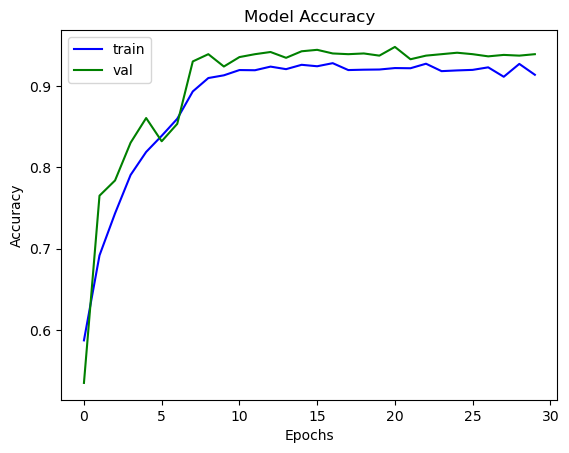

In [62]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

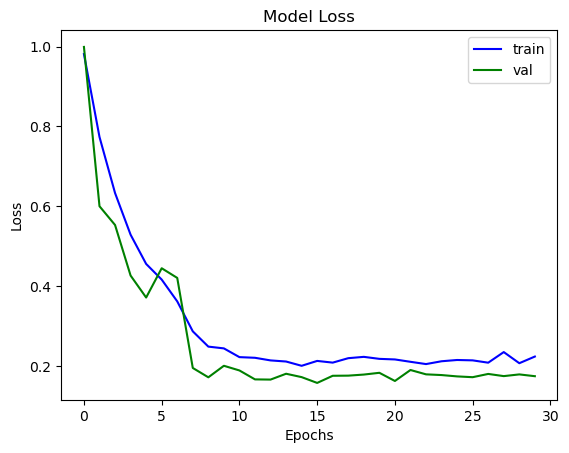

In [63]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

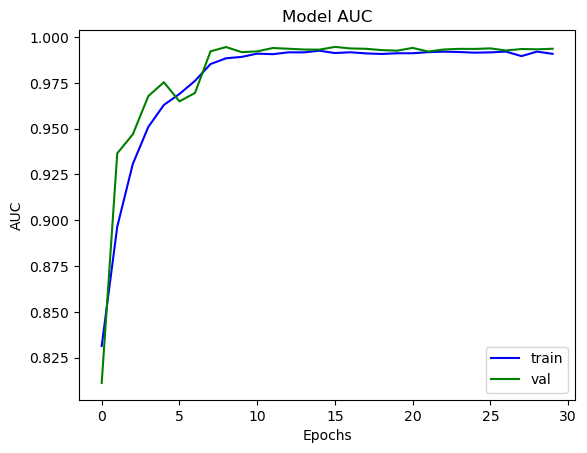

In [64]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

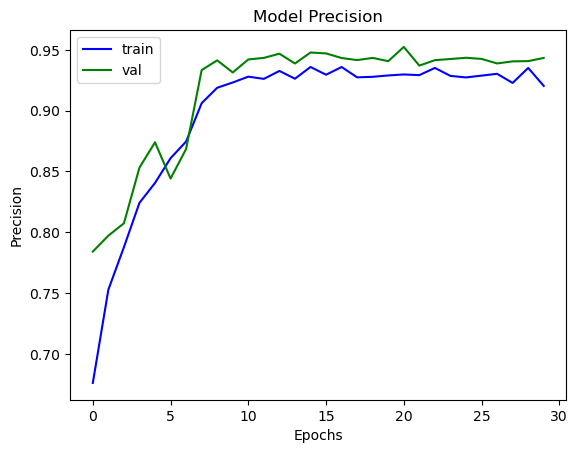

In [65]:
plt.plot(history.history['precision'], 'b')
plt.plot(history.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

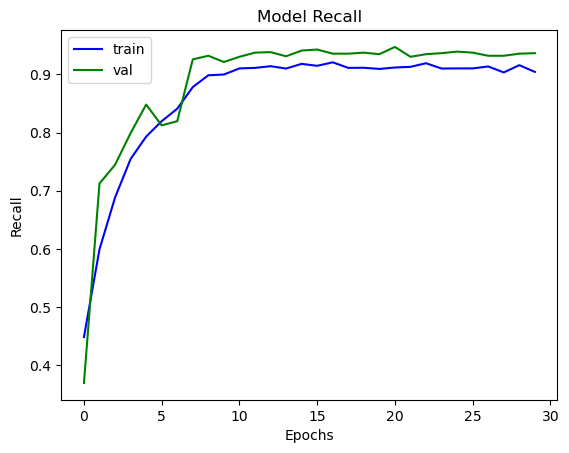

In [66]:
plt.plot(history.history['recall'], 'b')
plt.plot(history.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

In [67]:
del history #no more required

In [68]:
pred_labels = TDD_model.predict(x_test, batch_size=4)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

# Apply rounding to each set of predicted labels
rounded_pred_labels = [roundoff(labels) for labels in pred_labels]

print(classification_report(y_test, rounded_pred_labels, target_names=CLASSES))

281/281 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

      glioma       0.92      0.94      0.93       269
  meningioma       0.93      0.84      0.88       260
    no_tumor       0.96      0.99      0.98       308
   pituitary       0.95      0.99      0.97       287

   micro avg       0.94      0.94      0.94      1124
   macro avg       0.94      0.94      0.94      1124
weighted avg       0.94      0.94      0.94      1124
 samples avg       0.94      0.94      0.94      1124



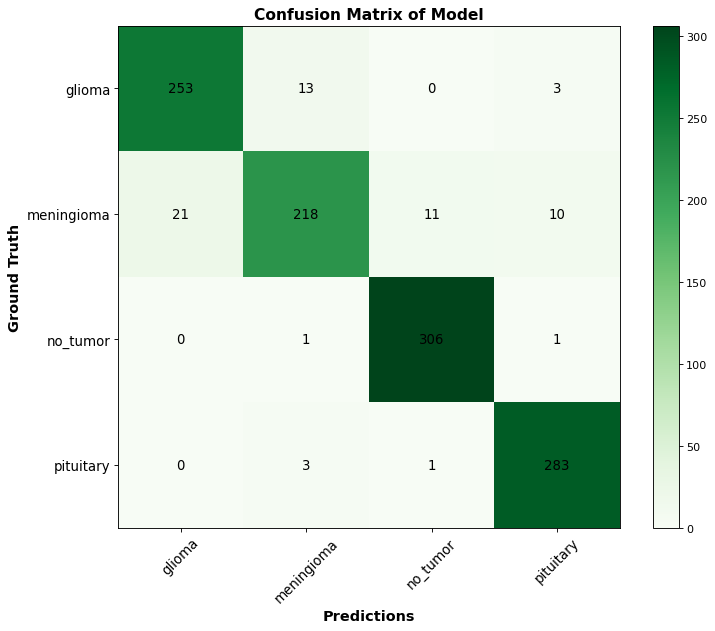

In [69]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

# Assuming pred_ls and test_ls are already defined
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plotting the confusion matrix using matplotlib
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Create a grid of subplots (1 row x 1 column)
ax = plt.subplot(111)

# Show the matrix using imshow
cax = ax.imshow(conf_arr, interpolation='nearest', cmap='Greens')

# Add a color bar
plt.colorbar(cax)

# Add title and axis labels
plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)

# Define the tick marks
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, fontsize=12)
plt.yticks(tick_marks, CLASSES, fontsize=12)

# Annotate each cell with the numeric values
for i in range(conf_arr.shape[0]):
    for j in range(conf_arr.shape[1]):
        plt.text(j, i, str(conf_arr[i, j]), horizontalalignment="center", verticalalignment="center", color="black", fontsize=12)

# Adjust layout to ensure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


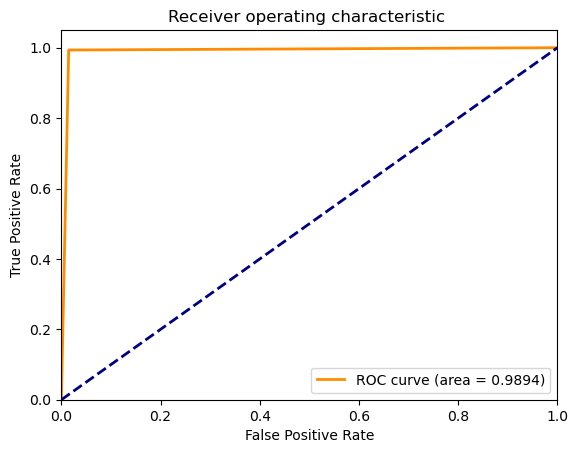

In [70]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

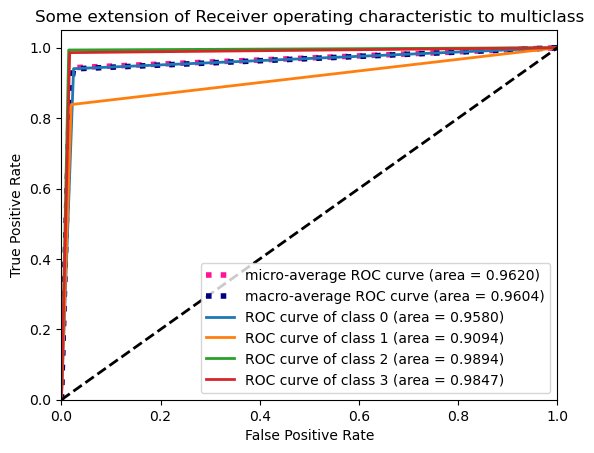

In [71]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()